In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import re
import time
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from pygments.lexers import CLexer
from pygments import lex
from imblearn.over_sampling import RandomOverSampler
import random
import string
import xgboost as xgb
from scipy import sparse

In [3]:
# Fix random seeds for reproducibility
np.random.seed(42)
random.seed(42)

# Load Dataset
# Sample a subset to fit into memory while ensuring balanced classes
data_path = '/content/drive/MyDrive/704/MSR_data_cleaned.csv'

with open(data_path, 'r') as file:
    total_rows = sum(1 for _ in file)

chunk_size = 100000
chunks = []

# Identify rows with issues to skip
rows_to_skip = [188535]

for chunk in pd.read_csv(data_path, chunksize=chunk_size, on_bad_lines='skip', skiprows=rows_to_skip, low_memory=False):
    chunks.append(chunk)

df = pd.read_csv(data_path, on_bad_lines='skip', skiprows=rows_to_skip, low_memory=False)
print("Dataset shape:", df.shape)

Dataset shape: (188534, 36)


In [4]:
# Prepare features and labels
X = df['func_before']  # Replace with your actual code column name
y = df['vul'].apply(lambda x: 1 if int(x) > 0 else 0)  # Ensure labels are binary (0 or 1)

In [5]:
# Split the data
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)
X_train_original, X_val, y_train_original, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)  # 0.25 x 0.8 = 0.20

print(f"Training set size: {len(X_train_original)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")

Training set size: 113120
Validation set size: 37707
Test set size: 37707


In [6]:
# Function to print class distribution
def print_class_distribution(y, dataset_name):
    unique, counts = np.unique(y, return_counts=True)
    class_counts = dict(zip(unique, counts))
    print(f"Class distribution in {dataset_name} set:", class_counts)

print_class_distribution(y_train_original, "Original Training")
print_class_distribution(y_val, "Validation")
print_class_distribution(y_test, "Test")

Class distribution in Original Training set: {0: 106642, 1: 6478}
Class distribution in Validation set: {0: 35547, 1: 2160}
Class distribution in Test set: {0: 35547, 1: 2160}


In [7]:
# Preprocessing function
def preprocess_code(code):
    code = re.sub(r'//.*', '', code)  # Remove single-line comments
    code = re.sub(r'/\*.*?\*/', '', code, flags=re.DOTALL)  # Remove multi-line comments
    code = re.sub(r'".*?"', '', code)  # Remove string literals
    code = re.sub(r'\b[-+]?\d*\.?\d+\b', 'NUMBER', code)  # Normalize numbers
    return code.strip()

In [8]:
# Data Augmentation: Variable Renaming
c_keywords = set([
    'auto', 'break', 'case', 'char', 'const', 'continue', 'default',
    'do', 'double', 'else', 'enum', 'extern', 'float', 'for', 'goto',
    'if', 'inline', 'int', 'long', 'register', 'restrict', 'return',
    'short', 'signed', 'sizeof', 'static', 'struct', 'switch', 'typedef',
    'union', 'unsigned', 'void', 'volatile', 'while', '_Alignas',
    '_Alignof', '_Atomic', '_Bool', '_Complex', '_Generic', '_Imaginary',
    '_Noreturn', '_Static_assert', '_Thread_local', 'NUMBER',
    # Add more C++ keywords
    'asm', 'bool', 'catch', 'class', 'const_cast', 'delete', 'dynamic_cast',
    'explicit', 'export', 'false', 'friend', 'mutable', 'namespace', 'new',
    'operator', 'private', 'protected', 'public', 'reinterpret_cast',
    'static_cast', 'template', 'this', 'throw', 'true', 'try', 'typeid',
    'typename', 'using', 'virtual', 'wchar_t'
])

def rename_variables(code):
    # Pattern to find identifiers (variable and function names)
    pattern = r'\b([a-zA-Z_][a-zA-Z0-9_]*)\b'

    # Find all identifiers in the code
    identifiers = set(re.findall(pattern, code))
    # Exclude keywords
    identifiers = identifiers - c_keywords

    # Create a mapping from original names to new random names
    new_names = {}
    for identifier in identifiers:
        # Generate a random name
        random_name = ''.join(random.choices(string.ascii_letters, k=8))
        new_names[identifier] = random_name

    # Replace identifiers in the code
    def replace_identifier(match):
        word = match.group(0)
        return new_names.get(word, word)

    # Replace all occurrences using the pattern
    augmented_code = re.sub(pattern, replace_identifier, code)
    return augmented_code

# Apply data augmentation to training data
augmentation_factor = 1  # Adjust as needed
X_train_augmented = []
y_train_augmented = []

In [9]:

for code, label in zip(X_train_original, y_train_original):
    # Add the original code
    X_train_augmented.append(code)
    y_train_augmented.append(label)

    # Generate augmented samples
    for _ in range(augmentation_factor):
        augmented_code = rename_variables(code)
        X_train_augmented.append(augmented_code)
        y_train_augmented.append(label)

# Convert to pandas Series
X_train_augmented = pd.Series(X_train_augmented)
y_train_augmented = pd.Series(y_train_augmented)

# Apply preprocessing
X_train_augmented = X_train_augmented.apply(preprocess_code)
X_val = X_val.apply(preprocess_code)
X_test = X_test.apply(preprocess_code)

In [10]:
# Tokenization function
def clexer_tokenize(code):
    lexer = CLexer()
    try:
        tokens = ' '.join([token[1] for token in lex(code, lexer)])
    except:
        tokens = ''
    return tokens

# Tokenize the code snippets
X_train_tokenized = X_train_augmented.apply(clexer_tokenize)
X_val_tokenized = X_val.apply(clexer_tokenize)
X_test_tokenized = X_test.apply(clexer_tokenize)

In [11]:
# Vectorization with TF-IDF
vectorizer = TfidfVectorizer(max_features=5000, lowercase=False, min_df=2)
X_train_vectorized = vectorizer.fit_transform(X_train_tokenized)
X_val_vectorized = vectorizer.transform(X_val_tokenized)
X_test_vectorized = vectorizer.transform(X_test_tokenized)

print("Training data shape:", X_train_vectorized.shape)
print("Validation data shape:", X_val_vectorized.shape)
print("Test data shape:", X_test_vectorized.shape)

Training data shape: (226240, 5000)
Validation data shape: (37707, 5000)
Test data shape: (37707, 5000)


In [12]:
# Handle class imbalance
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_vectorized, y_train_augmented)

print("Resampled training data shape:", X_train_resampled.shape)
print_class_distribution(y_train_resampled, "Resampled Training")

Resampled training data shape: (426568, 5000)
Class distribution in Resampled Training set: {0: 213284, 1: 213284}


In [13]:
# Convert to DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train_resampled, label=y_train_resampled)
dval = xgb.DMatrix(X_val_vectorized, label=y_val)
dtest = xgb.DMatrix(X_test_vectorized, label=y_test)

In [14]:
# Calculate scale_pos_weight
from collections import Counter

counter = Counter(y_train_resampled)
majority = counter[0]
minority = counter[1]
scale_pos_weight = majority / minority

print(f"Scale Pos Weight: {scale_pos_weight}")

Scale Pos Weight: 1.0


In [15]:
# XGBoost Model Training with GPU
xgb_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'tree_method': 'gpu_hist',
    'gpu_id': 0,
    'scale_pos_weight': scale_pos_weight,
    'max_depth': 5,
    'learning_rate': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.1,
    'reg_lambda': 1.0,
    'random_state': 42
}

evals = [(dtrain, 'train'), (dval, 'eval')]

In [16]:
# Train the model with early stopping
num_boost_round = 1000
early_stopping_rounds = 10

train_start = time.time()
bst = xgb.train(
    params=xgb_params,
    dtrain=dtrain,
    num_boost_round=num_boost_round,
    evals=evals,
    early_stopping_rounds=early_stopping_rounds,
    verbose_eval=True
)
train_time = time.time() - train_start
print(f"Training time: {train_time / 60:.2f} minutes")

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:19:22] WARNING: /workspace/src/common/error_msg.cc:45: `gpu_id` is deprecated since2.0.0, use `device` instead. E.g. device=cpu/cuda/cuda:0
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:19:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[0]	train-auc:0.66059	eval-auc:0.64563
[1]	train-auc:0.68915	eval-auc:0.67610
[2]	train-auc:0.69922	eval-auc:0.68278
[3]	train-auc:0.70201	eval-auc:0.68297
[4]	train-auc:0.70374	eval-auc:0.68365
[5]	train-auc:0.71170	eval-auc:0.69211
[6]	train-auc:0.71410	eval-auc:0.69595
[7]	train-auc:0.71616	eval-auc:0.69885
[8]	train-auc:0.71664	eval-auc:0.69906
[9]	train-auc:0.71768	eval-auc:0.70071
[10]	train-auc:0.71907	eval-auc:0.70225
[11]	train-auc:0.71996	eval-auc:0.70321
[12]	train-auc:0.72144	eval-auc:0.70537
[13]	train-auc:0.72297	eval-auc:0.70707
[14]	train-auc:0.72435	eval-auc:0.70890
[15]	train-auc:0.72561	eval-auc:0.71040
[16]	train-auc:0.72672	eval-auc:0.71205
[17]	train-auc:0.72819	eval-auc:0.71322
[18]	train-auc:0.72922	eval-auc:0.71461
[19]	train-auc:0.73046	eval-auc:0.71642
[20]	train-auc:0.73136	eval-auc:0.71744
[21]	train-auc:0.73240	eval-auc:0.71849
[22]	train-auc:0.73332	eval-auc:0.71967
[23]	train-auc:0.73451	eval-auc:0.72072
[24]	train-auc:0.73525	eval-auc:0.72158
[25]	train

In [17]:
# Evaluate the model on the test set
y_test_pred_prob = bst.predict(dtest)
y_test_pred = (y_test_pred_prob >= 0.5).astype(int)

test_accuracy_xgb = accuracy_score(y_test, y_test_pred)
print(f"XGBoost Test Accuracy: {test_accuracy_xgb:.2f}")
print("Test Classification Report:")
print(classification_report(y_test, y_test_pred))

XGBoost Test Accuracy: 0.78
Test Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.79      0.87     35547
           1       0.15      0.62      0.25      2160

    accuracy                           0.78     37707
   macro avg       0.56      0.71      0.56     37707
weighted avg       0.92      0.78      0.84     37707



/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:19:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


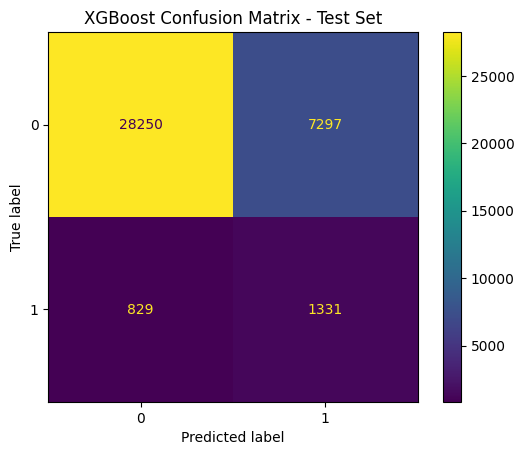

In [18]:
# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred)
plt.title('XGBoost Confusion Matrix - Test Set')
plt.show()

In [19]:
# Feature Importance
importances = bst.get_score(importance_type='gain')
importances = {vectorizer.get_feature_names_out()[int(k[1:])]: v for k, v in importances.items()}
sorted_importances = sorted(importances.items(), key=lambda item: item[1], reverse=True)

# Print the top 20 features
print("Top 20 Important Features:")
for feature, importance in sorted_importances[:20]:
    print(f"{feature}: {importance:.4f}")

Top 20 Important Features:
v8: 325.6450
while: 292.7331
else: 288.5895
NUMBER: 273.7467
MAYBE_MISSING_PARAMETER: 254.4589
sizeof: 224.0546
switch: 194.3581
this: 183.6596
PNG_CONST: 173.9930
default: 170.4141
static: 167.0229
FunctionCallbackInfo: 166.9600
GLES2DecoderImpl: 166.3823
ND_PRINT: 163.2406
if: 160.6336
Document: 146.8983
long: 143.2000
new: 141.0021
OM_uint32: 139.0647
register: 135.4797
